# Fall detector
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [2]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will use the previously learned data analysis methods and apply them to create a fall detector. After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating a fall detector.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. Finally, in part 4 you will create a fall detector.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- apply analysis methods for creating a fall detector.

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

> (For iPhone) If you have issues accessing the (live) calibrated data of the _Sensor Logger_ app, you need to enable motion and compas calibration on your phone as explained [here](https://www.lifewire.com/how-to-calibrate-an-iphone-4172146). You will notice this once the live view and the export yield empty results.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the data that you have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Load one of your individuals recordings in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [52]:
#// BEGIN_TODO [5ARB0_FallDetector_2_1] Read, merge and select data

def readDataFromCSV(acc_CSV, gyro_CSV, grav_CSV):
    '''
    Reads the data from the CSV files and returns them
    :params: the 3 datasets to be read
    returns 3 datasets as a dataframe
    '''
    acc_df = pd.read_csv(acc_CSV)
    gyro_df = pd.read_csv(gyro_CSV)
    grav_df = pd.read_csv(grav_CSV)
    return acc_df, gyro_df, grav_df

def MergeDatasets(acc_df, gyro_df, grav_df):
    '''
    Merges the datasets given as params
    :params: the 3 datasets to be merged
    returns a dataframe
    '''
    tolerance = 0.1
    # combine acc and gyro
    df = pd.merge_asof(acc_df, gyro_df, on='seconds_elapsed', suffixes=['', '_gyro'], tolerance= tolerance, direction='nearest')
    # combine acc+gyro and grav
    df = pd.merge_asof(df, grav_df, on='seconds_elapsed', suffixes=['_acc', '_grav'], tolerance= tolerance, direction='nearest')

    #remove unused columns, nan and duplicates
    df = df.drop(columns=['time_acc', 'time_gyro', 'time_grav']).drop_duplicates().dropna()

    return df

#// END_TODO [5ARB0_FallDetector_2_1]

In [86]:
acc_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Accelerometer.csv"
grav_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gravity.csv"
gyro_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gyroscope.csv"

# read data
acc_df, gyro_df, grav_df = readDataFromCSV(acc_CSV, gyro_CSV, grav_CSV)
# merge data
data = MergeDatasets(acc_df, gyro_df, grav_df)

#show data
data

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

### End of exercise 2.1
---
---

In order to restrict our focus to fall detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [70]:
#// BEGIN_TODO [5ARB0_FallDetector_2_2] Trim data

def trimDataset(data: pd.DataFrame, fromStart= 5, fromEnd=5):
    '''
    Removes 'fromStart' number of seconds from the begging of the sample and removes 'fromEnd' number of seconds from the begging
    :fromStart: the number of seconds to be removed from the begging of the record
    :fromEnd: the number of seconds to be removed from the end of the record
    @returns the trimmed dataset
    '''
    
    # from the begging
    data = data.drop(
        data[data['seconds_elapsed'] < fromStart].index
    )

    # from the end
    data = data.drop(
        data[data['seconds_elapsed'] > data['seconds_elapsed'].max() - fromEnd].index
    )

    return data
    

#// END_TODO [5ARB0_FallDetector_2_2]

In [71]:
data_trimmed = trimDataset(data)
data_trimmed

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
543,7.268935,-0.137248,0.698496,1.141784,0.154463,1.039564,0.729439,1.777337,-8.923182,-3.659001
544,7.278969,-0.238461,0.296979,1.085707,0.154463,1.039564,0.729439,1.870167,-8.877235,-3.723917
545,7.289002,-0.562388,-0.750215,1.297325,0.154463,1.039564,0.729439,1.974771,-8.825411,-3.792463
546,7.299035,-1.362981,-1.764613,1.720465,0.154463,1.039564,0.729439,2.096213,-8.771613,-3.851634
547,7.309070,-2.406208,-2.324449,2.089088,0.154463,1.039564,0.729439,2.230479,-8.717321,-3.899184
...,...,...,...,...,...,...,...,...,...,...
1791,21.905820,-3.938864,-4.210360,-3.655980,-6.281327,1.412406,1.495098,8.512507,4.721923,-1.187882
1792,21.915836,-2.959685,-3.344396,-3.447975,-5.839376,2.067277,1.587775,8.407792,4.770100,-1.650931
1793,21.925852,-1.804575,-2.564031,-3.399087,-5.380380,2.150368,1.683649,8.286499,4.806302,-2.098524
1794,21.935868,-0.643910,-1.900748,-3.655062,-4.877709,1.597629,1.731586,8.165960,4.833255,-2.475303


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [80]:
#// BEGIN_TODO [5ARB0_FallDetector_2_3] Normalize recordings

# ===== =====> Replace this line by your code. <===== ===== #

def normaliseDataset(df: pd.DataFrame):
    # dataset[column] -= dataset[column].mean()
    # dataset[column] /= dataset[column].std()
    # normalized_df = (df[]-df.mean())/df.std()
    
    _, x = df.shape
    for i in range(x):
        df.iloc[:,i] -= df.iloc[:,i].mean()
        df.iloc[:,i] /= df.iloc[:,i].std()

    return df

#// END_TODO [5ARB0_FallDetector_2_3]

In [81]:
data_norm = normaliseDataset(data_trimmed) 
data_norm 
# ? normalize seconds as well? not sure

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
543,-1.196621,-0.058938,0.431675,0.506540,0.402246,0.732932,0.331668,0.795721,-0.207579,-0.380746
544,-1.194375,-0.080327,0.329339,0.484583,0.402246,0.732932,0.331668,0.829152,-0.186270,-0.453115
545,-1.192128,-0.148784,0.062437,0.567440,0.402246,0.732932,0.331668,0.866824,-0.162236,-0.529529
546,-1.189881,-0.317975,-0.196106,0.733114,0.402246,0.732932,0.331668,0.910560,-0.137286,-0.595493
547,-1.187635,-0.538443,-0.338793,0.877443,0.402246,0.732932,0.331668,0.958915,-0.112107,-0.648502
...,...,...,...,...,...,...,...,...,...,...
1791,2.080727,-0.862343,-0.819461,-1.371959,-4.083097,1.032084,0.735996,3.221310,6.120615,2.374047
1792,2.082970,-0.655411,-0.598750,-1.290517,-3.775084,1.557523,0.784937,3.183598,6.142958,1.857841
1793,2.085212,-0.411298,-0.399856,-1.271376,-3.455193,1.624191,0.835566,3.139916,6.159747,1.358867
1794,2.087455,-0.166012,-0.230803,-1.371599,-3.104863,1.180699,0.860881,3.096505,6.172247,0.938835


### End of exercise 2.3
---
---

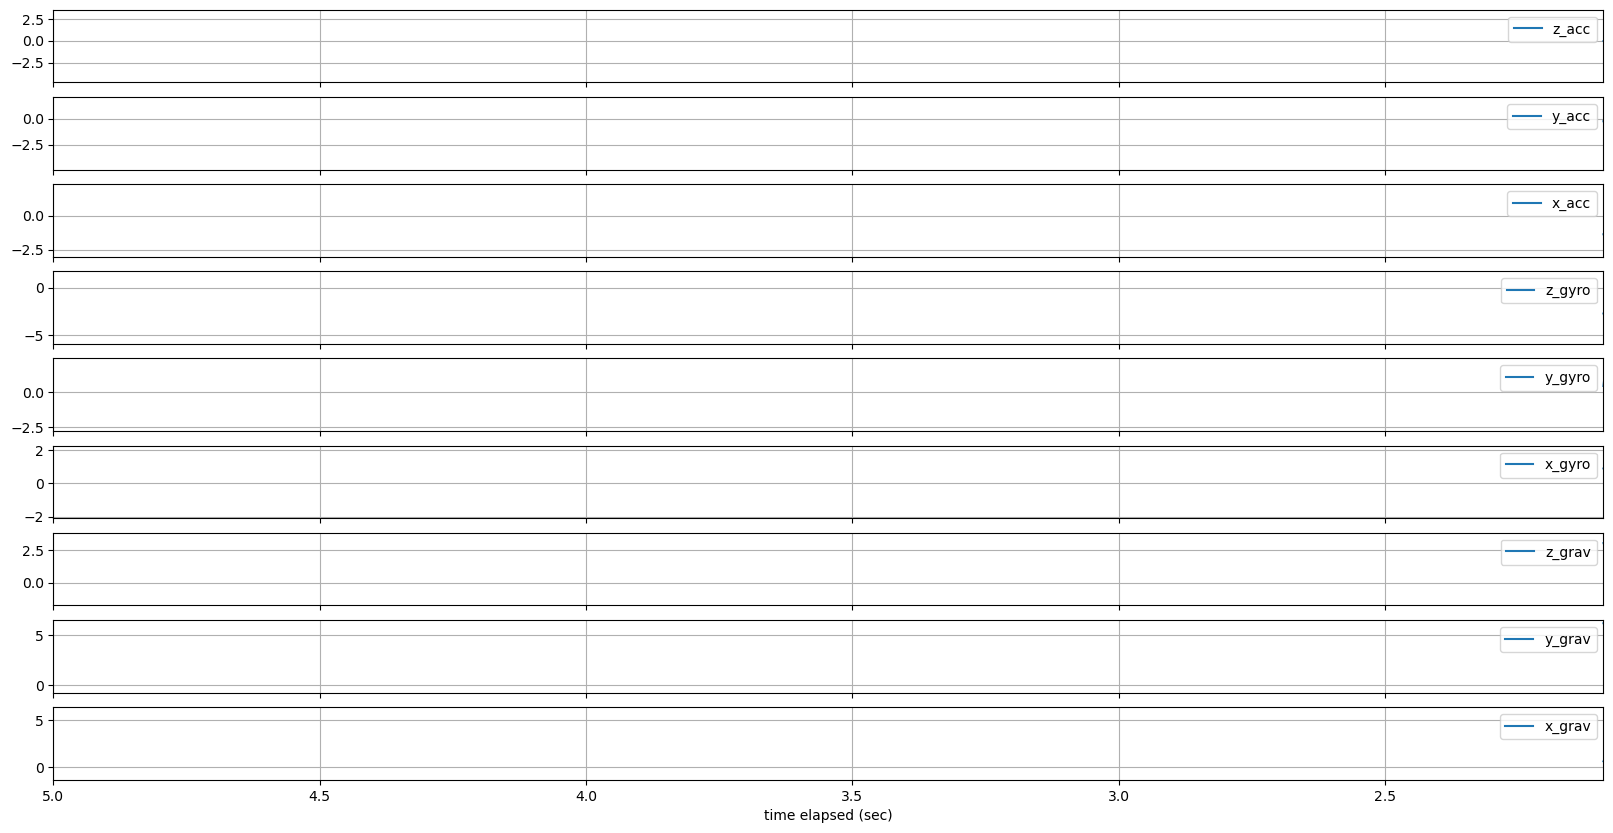

In [85]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for detecting a fall. Based on the measurements at a specific point of time, it is difficult to determine whether someone has allen. Instead, it would be more appropriate to perform the fall detection over _segments_ of time. In this part you will extract features that will be used for detecting falls. But first all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_3_1] Merge all datasets

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_3_1]

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert data frame to matrix
In order to extract features from the recording, first convert the dataframe to a Numpy matrix called `mat`. This matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the fall detector.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_3_2] Convert data frame to matrix

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_3_2]

### End of exercise 3.2
---
---

Now that the data frame has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features. As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of the matrix `mat`. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_)

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_3_3] Process segments

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_3_3]

In [ ]:
Y_mean = process_segment(mat, "mean", 100, 50)
Y_std = process_segment(mat, "std", 100, 50)
Y_minimum = process_segment(mat, "minimum", 100, 50)
Y_maximum = process_segment(mat, "maximum", 100, 50)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them into a single matrix. Create the matrix `features` which concatenates the above results along the appropriate axis.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_3_4] Concatenate features

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_3_4]

### End of exercise 3.4
---
---

## Part 4: Fall detector
In this part of the assignment we will use the previously implemented data analysis methods to create a simple fall detector. You will be given more freedom to experiment with the different techniques used.

During this part you can make use of the `sklearn` (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets.

In [ ]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

---
---
### Exercise 4.1: Fall detector
In this assignment you will create your own fall detector, using the previously recorded data and learned data analysis methods. You are free to add more features to the dataset if you want. Possible steps include: 1) feature extraction, 2) data compression and 3) clustering.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_4_1]

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Fall classification
Use your fall detector to classify when someone has fallen. Plot your fall classification over time.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_4_2] Classify falls

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_4_2]

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Classification improvements
You might have noticed that it is not easy to create a fall detector. How do you think that you could improve the performance? Please carefully describe the current flaws and ways to deal with them, together with a list of next steps that you would take. Please elaborate on your answer.

### End of exercise 4.3
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.